# Next steps in this code

- Change the output file format.  This could go straight into an xarray/netcdf rather than a pickle
- Change the download of timeseries/ data to only load an update to the time series, and then merge with  data that was already downloaded.  Should be faster
- Add Wetlabs data to be downloaded: Not currently downloading.
 

In [5]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import datetime
import json
from io import StringIO
import requests
from setdir import *
import ast # To handle the string conversion when loading json file

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Get a token

https://api.c2.noc.ac.uk/charon/tokens/issue


In [6]:
# Need to copy and paste the token you generated by logging in at the website
# above into the file myToken.txt
with open("myToken.txt", "r") as myfile:
    myToken = myfile.read().replace('\n', '')
    
from requests.structures import CaseInsensitiveDict
headers = CaseInsensitiveDict()
headers["Accept"] = "application/json"
headers["Authorization"] = f'Bearer {myToken}'

## Choose the request options

For time series data, the website is: https://api.c2.noc.ac.uk/timeseries/doc
Check under 'meta/variables' to see what variables can be selected.

Be sure to choose platform: slocum and serial number: unit_409 or unit_398

For positioning data, it's: https://api.c2.noc.ac.uk/positions/doc

An example to download time series data is 
https://api.c2.noc.ac.uk/timeseries/observations/csv_combined?variable=sci_water_pressure&variable=sci_water_temp&variable=sci_water_cond&variable=sci_oxy4_oxygen&variable=sci_bb2flsv9_chl_scaled&variable=derived_salinity&variable=derived_potential_density&variable=derived_potential_temperature&platform_type=slocum&platform_serial=unit_409&reverse_order=false&skip_nulls=false&cached=false


In [15]:
api_root = 'https://api.c2.noc.ac.uk/'

# Choose the unit number (unit_409 or unit_398 for TERIFIC2)
platform = 'slocum'
unit_list = ['unit_398', 'unit_409']

# Choose a start date.  Earliest valid data is 2021-12-12, but there were some in-air measurements before
dstart = '2021-12-12T00%3A00%3A00'
dstart = '2021-12-25T00%3A00%3A00'


# Choose a bunch of variable names
var_list = ['sci_water_pressure', 'sci_water_temp', 'sci_water_cond',
            'sci_oxy4_oxygen',
            'derived_salinity',
            'derived_potential_density', 'derived_potential_temperature',
            'm_gps_lon', 'm_gps_lat',
           ]
wetlabs398 = ['sci_bb2flsv9_b532_scaled', # units ug/l  - 398
            'sci_bb2flsv9_b700_scaled', # units ug/l
            'sci_bb2flsv9_chl_scaled', # units ug/l
           ]
wetlabs409 = ['sci_flbbcd_cdom_units', # ppb - 409
              'sci_flbbcd_chlor_units', # ug/l
              'sci_flbbcd_bb_units', # ???
             ]

var_list = var_list+wetlabs398+wetlabs409

# ISSUE: No wetlabs data
# Hmm. removed the wetlabs because it seemed to remove some of the 
# data/discretise it so that not all the T&S came down
#var_list = ['sci_water_pressure', 'sci_water_temp', 'sci_water_cond',
#            'sci_oxy4_oxygen','derived_salinity', 'derived_potential_density',
#            'derived_potential_temperature', 'm_gps_lon', 'm_gps_lat']

var_str = ''
for i in var_list:
    var_str = var_str+'variable='+i+'&'

print(var_str)

# Choose which of the api websites to use.. Not sure how many there are but for these data, it's timeseries/
api_choice = 'timeseries/observations/'

# Using csv_combined_transposed rather than csv_combined since it seems to 
# help with getting all the data (not just when the wetlabs was on)
format_choice = 'csv_combined_transposed?'



variable=sci_water_pressure&variable=sci_water_temp&variable=sci_water_cond&variable=sci_oxy4_oxygen&variable=derived_salinity&variable=derived_potential_density&variable=derived_potential_temperature&variable=sci_bb2flsv9_b532_scaled&variable=sci_bb2flsv9_b700_scaled&variable=sci_bb2flsv9_chl_scaled&variable=sci_flbbcd_cdom_units&variable=sci_flbbcd_chlor_units&variable=sci_flbbcd_bb_units&


## Loop through both vehicles

Goes through the serial numbers in unit_list and loads the data.  Not sure whether I want to cut the start, but will decide later.
Saves a pickle with the data in ../data/interim/

In [16]:
# ISSUE: Set up a boolean to decide whether to use a time limited download (from dstart to present) or the full dataset including in-air measurements

# Check that the output directory exists
# If not, then exit
outpath = cat_interim_path('')
if not os.path.isdir(outpath):
   sys.exit(1)


for i in unit_list:
    #--------------------------------------------------------------
    # Format the request
    #--------------------------------------------------------------
    # Time limited
    opt_str = f'from={dstart}&{var_str}platform_type={platform}&platform_serial={i}&reverse_order=false&skip_nulls=false&cached=false'
    start_yyyymmdd = '_'+str.replace(dstart[0:10],'-','')
    
    # No time limiting - Download everything
    opt_str = f'{var_str}platform_type={platform}&platform_serial={i}&reverse_order=false&skip_nulls=false&cached=false'
    start_yyyymmdd = ''

    # Concatinate request string
    url = api_root+api_choice+format_choice+opt_str

    #--------------------------------------------------------------
    # Request the data - save as text in variable 'resp'
    #--------------------------------------------------------------
    resp = requests.get(url, headers=headers)

    # Print the response code (200 is good.  If you get something else, token 
    # may need refreshing)
    print(resp.status_code)

    # Parse the 'resp' string into a dataFrame
    aa = resp.content.decode("utf-8") 
    data_df = pd.read_csv(StringIO(aa)) # Get rid of the leading b
    # Sort by time
    data_df = data_df.sort_values(['timestamp'])

    # Print a little table to the screen
    #    print(data_df.head(3))

    #--------------------------------------------------------------
    # Format the output file name (and path in ../01-data/01-raw/
    #--------------------------------------------------------------

    # Get a string for today (could be date range in data instead)
    #yyyymmdd = str(today.year)+str(today.month)+str(today.day)
    yyyymmdd = datetime.date.today().strftime('%Y%m%d')

    outfile = i+start_yyyymmdd+'_'+yyyymmdd+'.pkl'
    outfile_with_path = cat_raw_path(outfile)
    data_df.to_pickle(outfile_with_path)

    


200
200


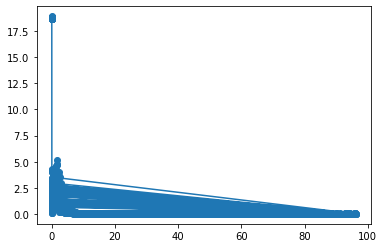

In [17]:
# Decide format for netcdf output
plt.plot(data_df.sci_water_pressure, data_df.sci_bb2flsv9_chl_scaled, marker='o')

# Get the position data separately

Exmaple of a request
https://api.c2.noc.ac.uk/positions/positions?platform_type=slocum&platform_serial=unit_409&source_type=internal&time_order=descending




In [ ]:
# Hmm. removed the wetlabs because it seemed to remove some of the 
# data/discretise it so that not all the T&S came down
api_root = 'https://api.c2.noc.ac.uk/'

   
# Choose which of the api websites to use.. Not sure how many there are but 
# for these data, it's timeseries/
api_choice = 'positions/'
format_choice = 'positions?'


# Choose the unit number (unit_409 or unit_398 for TERIFIC2)
platform = 'slocum'
unit_list = ['unit_398', 'unit_409']

# Choose a start date.  Earliest valid data is 2021-12-12, but there were some in-air measurements before
dstart = '2021-12-12T00%3A00%3A00'
dstart = '2021-12-25T00%3A00%3A00'


for i in unit_list:
    # Time limited
    opt_str = f'from={dstart}&platform_type={platform}&platform_serial={i}&source_type=internal&time_order=descending'
    start_yyyymmdd = '_'+str.replace(dstart[0:10],'-','')
    
    # No time limiting
    opt_str = f'platform_type={platform}&platform_serial={i}&source_type=internal&time_order=descending'
    start_yyyymmdd = ''

    # Concatinate request string
    url = api_root+api_choice+format_choice+opt_str

    # Get the data
    resp = requests.get(url, headers=headers)

    # Print the response code (200 is good.  If you get something else, token may need refreshing)
    print(resp.status_code)

    # Parse the string into a dataFrame
    json_string = resp.content.decode("utf-8") # Get rid of the leading b
    bb = ast.literal_eval(json_string)
    bb = bb[0]
    glider_path = pd.DataFrame(bb['positions']['internal'])
    glider_path.head()

    # Format the output file name (and path in ../data/interim/)

    # Get a string for today (could be date range in data instead)
#    today = datetime.datetime.now()
#    yyyymmdd = str(today.year)+str(today.month)+str(today.day)
    yyyymmdd = datetime.datetime.now().strftime('%Y%m%d')

    outfile = i+'_positions'+start_yyyymmdd+'_'+yyyymmdd+'.pkl'
    outfile_with_path = cat_raw_path(outfile)
    glider_path.to_pickle(outfile_with_path)

    

